In [1]:
import numpy as np
import matplotlib.pyplot as plt
import bemcs


def linear_force_kernel_antiplane(xo, yo, xf, yf, w, mu):
    # Compute displacement and stress kernels for a linearly varying force on a
    # horizontal source element (-w <= x <= w, y = 0)
    #
    # INPUTS
    # xo, yo - observation locations provided as individual vectors [Nobs x 1]
    # xf, yf - source element center location (scalars)
    # w - source element half-length
    # mu - Elastic parameters
    #
    # OUTPUTS
    # Disp - 2-d displacement kernels [Nobs x 2 basis functions]
    # Stress - 3-d stress_kernels     [Nobs x (sx or sy) x 2 basis functions]
    #
    # AUTHORS
    # Rishav Mallick, JPL, 2024

    n_obs = len(xo)
    x = xo - xf
    y = yo - yf

    u_1 = (
        (1 / 16)
        * np.pi ** (-1)
        * w ** (-1)
        * (
            (-4) * w * (2 * w + x)
            + 4 * (w + x) * y * np.arctan2(w - x, y)
            + 4 * (w + x) * y * np.arctan2(w + x, y)
            + ((w + (-1) * x) * (3 * w + x) + y**2) * np.log((w + (-1) * x) ** 2 + y**2)
            + (w + x + (-1) * y) * (w + x + y) * np.log((w + x) ** 2 + y**2)
        )
    )

    u_2 = (
        (1 / 16)
        * np.pi ** (-1)
        * w ** (-1)
        * (
            4 * w * ((-2) * w + x)
            + 4 * (w + (-1) * x) * y * np.arctan2(w - x, y)
            + 4 * (w + (-1) * x) * y * np.arctan2(w + x, y)
            + (w + (-1) * x + (-1) * y)
            * (w + (-1) * x + y)
            * np.log((w + (-1) * x) ** 2 + y**2)
            + ((3 * w + (-1) * x) * (w + x) + y**2) * np.log((w + x) ** 2 + y**2)
        )
    )

    ex_1 = (
        (1 / 8)
        * np.pi ** (-1)
        * w ** (-1)
        * (
            (-4) * w
            + 2 * y * (np.arctan2(w - x, y) + np.arctan2(w + x, y))
            + (-1) * (w + x) * np.log((w + (-1) * x) ** 2 + y**2)
            + (w + x) * np.log((w + x) ** 2 + y**2)
        )
    )

    ex_2 = (
        (-1 / 8)
        * np.pi ** (-1)
        * w ** (-1)
        * (
            (-4) * w
            + 2 * y * (np.arctan2(w - x, y) + np.arctan2(w + x, y))
            + (w + (-1) * x)
            * (np.log((w + (-1) * x) ** 2 + y**2) + (-1) * np.log((w + x) ** 2 + y**2))
        )
    )

    ey_1 = (
        (1 / 8)
        * np.pi ** (-1)
        * w ** (-1)
        * (
            2 * (w + x) * (np.arctan2(w - x, y) + np.arctan2(w + x, y))
            + y
            * (np.log((w + (-1) * x) ** 2 + y**2) + (-1) * np.log((w + x) ** 2 + y**2))
        )
    )

    ey_2 = (
        (1 / 8)
        * np.pi ** (-1)
        * w ** (-1)
        * (
            2 * (w + (-1) * x) * (np.arctan2(w - x, y) + np.arctan2(w + x, y))
            + y
            * ((-1) * np.log((w + (-1) * x) ** 2 + y**2) + np.log((w + x) ** 2 + y**2))
        )
    )

    # Store displacement kernels (2-d matrix), [Nobs x 2 basis functions]
    disp = np.hstack((u_1, u_2))

    # Store stress kernels (3-d matrix), [Nobs x (sx or sy) x 2 basis functions]
    stress = np.zeros((n_obs, 2, 2))
    stress[:, 0, :] = np.hstack((mu * ex_1, mu * ex_2))
    stress[:, 1, :] = np.hstack((mu * ey_1, mu * ey_2))

    return disp, stress

In [2]:
def quadratic_slip_kernel_antiplane(xo, yo, xf=0, yf=0, w=1, mu=1):
    """compute displacement and stress kernels for a quadratically varying slip on a horizontal source element (-w <= x <= w, y = 0)

    INPUTS

    x,y - observation locations provided as individual vectors [Nobs x 1]
    xf,yf - source element center location (scalars)
    w - source element half-length
    mu - Shear modulus

    OUTPUTS

    Disp - displacement kernels [Nobs x 3 basis functions]
    Stress - 3-d stress_kernels     [Nobs x (sx or sy) x 3 basis functions]"""

    x = xo - xf
    y = yo - yf
    Nobs = len(x[:, 0])

    u1 = (
        (3 / 16)
        * w ** (-2)
        * np.pi ** (-1)
        * (
            6 * w * y
            + ((-2) * w * x + 3 * (x + (-1) * y) * (x + y))
            * np.arctan((w + (-1) * x) * y ** (-1))
            + ((-2) * w * x + 3 * (x + (-1) * y) * (x + y))
            * np.arctan((w + x) * y ** (-1))
            + (w + (-3) * x)
            * y
            * ((-1) * np.log((w + (-1) * x) ** 2 + y**2) + np.log((w + x) ** 2 + y**2))
        )
    )

    u2 = (
        (1 / 8)
        * w ** (-2)
        * np.pi ** (-1)
        * (
            (-18) * w * y
            + (4 * w**2 + 9 * y**2) * np.arctan((w + (-1) * x) * y ** (-1))
            + 9 * x**2 * np.arctan(((-1) * w + x) * y ** (-1))
            + (4 * w**2 + (-9) * x**2 + 9 * y**2) * np.arctan((w + x) * y ** (-1))
            + 9
            * x
            * y
            * ((-1) * np.log((w + (-1) * x) ** 2 + y**2) + np.log((w + x) ** 2 + y**2))
        )
    )

    u3 = (
        (3 / 16)
        * w ** (-2)
        * np.pi ** (-1)
        * (
            6 * w * y
            + (2 * w * x + 3 * (x + (-1) * y) * (x + y))
            * np.arctan((w + (-1) * x) * y ** (-1))
            + (2 * w * x + 3 * (x + (-1) * y) * (x + y))
            * np.arctan((w + x) * y ** (-1))
            + (w + 3 * x)
            * y
            * (np.log((w + (-1) * x) ** 2 + y**2) + (-1) * np.log((w + x) ** 2 + y**2))
        )
    )

    ex1 = (
        (3 / 32)
        * w ** (-2)
        * np.pi ** (-1)
        * (
            (-2)
            * (w + (-3) * x)
            * (np.arctan((w + (-1) * x) * y ** (-1)) + np.arctan((w + x) * y ** (-1)))
            + y
            * (
                w**2
                * (
                    (-1) * ((w + (-1) * x) ** 2 + y**2) ** (-1)
                    + 5 * ((w + x) ** 2 + y**2) ** (-1)
                )
                + 3 * np.log((w + (-1) * x) ** 2 + y**2)
                + (-3) * np.log((w + x) ** 2 + y**2)
            )
        )
    )

    ex2 = (
        (1 / 16)
        * w ** (-2)
        * np.pi ** (-1)
        * (
            (-18)
            * x
            * (np.arctan((w + (-1) * x) * y ** (-1)) + np.arctan((w + x) * y ** (-1)))
            + y
            * (
                20
                * w**3
                * x
                * (
                    (w**4 + 2 * w**2 * ((-1) * x**2 + y**2) + (x**2 + y**2) ** 2)
                    ** (-1)
                )
                + (-9) * np.log((w + (-1) * x) ** 2 + y**2)
                + 9 * np.log((w + x) ** 2 + y**2)
            )
        )
    )

    ex3 = (
        (3 / 32)
        * w ** (-2)
        * np.pi ** (-1)
        * (
            2
            * (w + 3 * x)
            * (np.arctan((w + (-1) * x) * y ** (-1)) + np.arctan((w + x) * y ** (-1)))
            + y
            * (
                w**2
                * (
                    (-5) * ((w + (-1) * x) ** 2 + y**2) ** (-1)
                    + ((w + x) ** 2 + y**2) ** (-1)
                )
                + 3 * np.log((w + (-1) * x) ** 2 + y**2)
                + (-3) * np.log((w + x) ** 2 + y**2)
            )
        )
    )

    ey1 = (
        (3 / 32)
        * w ** (-2)
        * np.pi ** (-1)
        * (
            w
            * (
                12
                + w * ((-1) * w + x) * ((w + (-1) * x) ** 2 + y**2) ** (-1)
                + (-5) * w * (w + x) * ((w + x) ** 2 + y**2) ** (-1)
            )
            + (-6)
            * y
            * (np.arctan((w + (-1) * x) * y ** (-1)) + np.arctan((w + x) * y ** (-1)))
            + (-1)
            * (w + (-3) * x)
            * (np.log((w + (-1) * x) ** 2 + y**2) + (-1) * np.log((w + x) ** 2 + y**2))
        )
    )

    ey2 = (
        (-1 / 16)
        * w ** (-2)
        * np.pi ** (-1)
        * (
            w
            * (
                36
                + 5 * w * ((-1) * w + x) * ((w + (-1) * x) ** 2 + y**2) ** (-1)
                + (-5) * w * (w + x) * ((w + x) ** 2 + y**2) ** (-1)
            )
            + (-18)
            * y
            * (np.arctan((w + (-1) * x) * y ** (-1)) + np.arctan((w + x) * y ** (-1)))
            + 9 * x * np.log((w + (-1) * x) ** 2 + y**2)
            + (-9) * x * np.log((w + x) ** 2 + y**2)
        )
    )

    ey3 = (
        (3 / 32)
        * w ** (-2)
        * np.pi ** (-1)
        * (
            w
            * (
                12
                + 5 * w * ((-1) * w + x) * ((w + (-1) * x) ** 2 + y**2) ** (-1)
                + (-1) * w * (w + x) * ((w + x) ** 2 + y**2) ** (-1)
            )
            + (-6)
            * y
            * (np.arctan((w + (-1) * x) * y ** (-1)) + np.arctan((w + x) * y ** (-1)))
            + (w + 3 * x)
            * (np.log((w + (-1) * x) ** 2 + y**2) + (-1) * np.log((w + x) ** 2 + y**2))
        )
    )

    sx = mu * np.hstack([ex1, ex2, ex3])
    sy = mu * np.hstack([ey1, ey2, ey3])

    # Create a 2D numpy array for displacements
    # Disp_kernels - [Nobs x 3 basis functions]
    Disp = np.hstack([u1, u2, u3])

    # Create a 3D numpy array for Stress
    # Stress_kernels - [Nobs x (sx or sy) x 3 basis functions]
    Stress = np.zeros((Nobs, 2, 3))

    # Assign values to the stress kernels
    Stress[:, 0, :] = sx
    Stress[:, 1, :] = sy

    return Disp, Stress

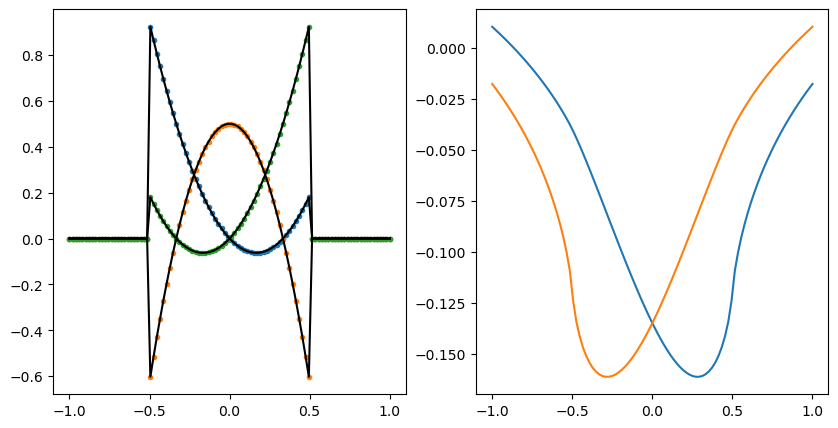

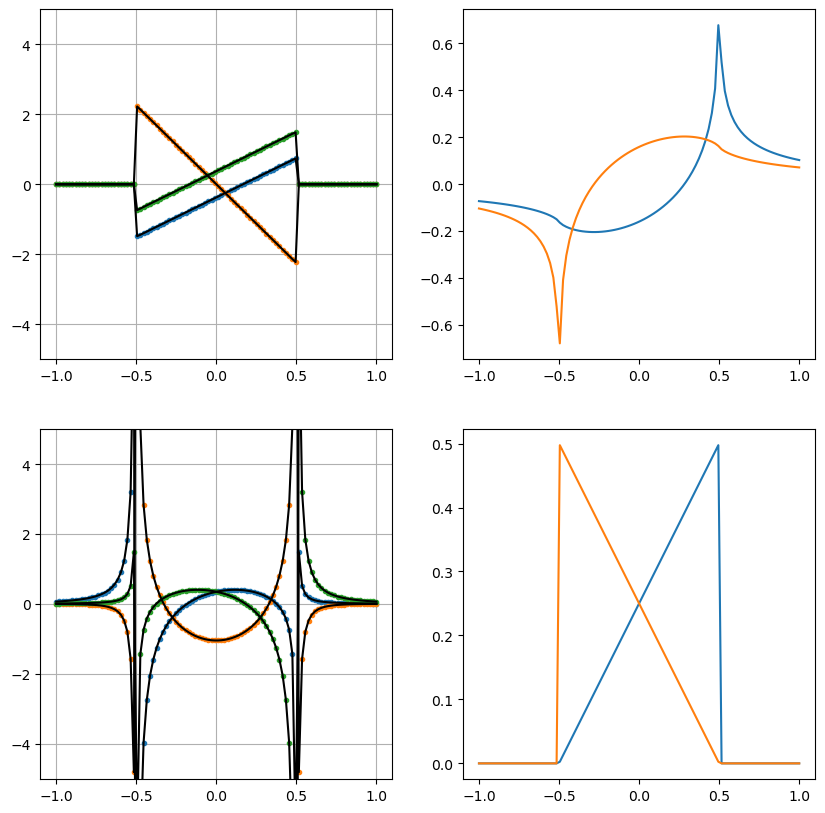

In [9]:
nu = 0.25
xo = np.linspace(-1, 1, 100).reshape(-1, 1)
yo = np.zeros_like(xo) + 1e-6
xf = 0.0
yf = 0.0
w = 0.5
mu = 1.0

disp_antiplane_force, stress_antiplane_force = linear_force_kernel_antiplane(
    xo, yo, xf, yf, w, mu
)

disp_antiplane_slip, stress_antiplane_slip = quadratic_slip_kernel_antiplane(
    xo, yo, xf, yf, w, mu
)

u, s = bemcs.displacements_stresses_quadratic_slip_no_rotation_antiplane(
    xo, yo, w, mu, xf, yf
)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(xo, disp_antiplane_slip[:, 0:], ".")
plt.plot(xo, u[:, 0:], "k-")

plt.subplot(1, 2, 2)
plt.plot(xo, disp_antiplane_force[:, 0:], "-")

plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(xo, stress_antiplane_slip[:, 0, :], ".")
plt.plot(xo, s[:, 0, :], "k-")
plt.grid()
plt.ylim([-5, 5])

plt.subplot(2, 2, 2)
plt.plot(xo, stress_antiplane_force[:, 0, :], "-")

plt.subplot(2, 2, 3)
plt.plot(xo, stress_antiplane_slip[:, 1, :], ".")
plt.plot(xo, s[:, 1, :], "k-")
plt.grid()
plt.ylim([-5, 5])

plt.subplot(2, 2, 4)
plt.plot(xo, stress_antiplane_force[:, 1, :], "-")
plt.show()